In [ ]:
# IMPORT PACKAGES
import rasterio
import numpy as np
import os  
import matplotlib.pyplot as plt
import geopandas as gpd
import xarray as xr
import hvplot.xarray 
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.ndimage import generic_filter
import cupy as cp
from scipy.stats import mode
from tkinter.filedialog import askopenfilenames
from tkinter import Tk, filedialog, simpledialog
from typing import Tuple 
from rasterio.warp import reproject, Resampling
from rasterio.enums import Resampling
from rasterio.transform import from_bounds
import panel as pn
import numpy as np
from matplotlib.figure import Figure

In [7]:
#BATCH GEOSPATIAL IMPORT - auto grid

# Open a file selection dialog for the user to select multiple raster files
root = Tk()
root.withdraw()  # Hide the root window
root.attributes("-topmost", True)  # Bring the dialog to the front

# Open the file selection dialog
raster_files = askopenfilenames(
    title="Select Raster Files",
    filetypes=[("GeoTIFF files", "*.tif"), ("All files", "*.*")]
)

# Lists to store data and corresponding file names
data = []  
names = []

# Determine the target grid size and transformation
target_transform = None
target_width = None
target_height = None
target_crs = None

# First, determine the common CRS and the bounding box that covers all rasters
for raster_file in raster_files:
    with rasterio.open(raster_file, 'r') as src:
        if target_crs is None:
            target_crs = src.crs  # Use the CRS from the first raster
        if target_transform is None:
            target_transform = src.transform  # Use the transform from the first raster
            target_width = src.width
            target_height = src.height
        else:
            # Adjust the target bounding box to encompass the new raster
            left, bottom, right, top = src.bounds
            existing_bounds = rasterio.transform.array_bounds(target_height, target_width, target_transform)
            new_bounds = (
                min(existing_bounds[0], left), 
                min(existing_bounds[1], bottom), 
                max(existing_bounds[2], right), 
                max(existing_bounds[3], top)
            )
            target_transform, target_width, target_height = rasterio.warp.calculate_default_transform(
                src.crs, target_crs, src.width, src.height, *new_bounds
            )

# Now, reproject and resample each raster to the common grid
for raster_file in raster_files:
    with rasterio.open(raster_file, 'r') as src:
        # Prepare the output array
        data_array = np.full((target_height, target_width), np.nan, dtype=np.float32)
        
        # Handle NoData value
        nodata_value = src.nodata
        if nodata_value is None:
            nodata_value = np.nan  # If NoData is not set, assume NaN
        
        # Reproject the source data to the target grid
        reproject(
            source=rasterio.band(src, 1),
            destination=data_array,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=target_transform,
            dst_crs=target_crs,
            resampling=Resampling.nearest,
            src_nodata=nodata_value,  # Specify the source NoData value
            dst_nodata=np.nan  # Use NaN as the destination NoData
        )

        # Append the resampled data and names to lists
        data.append(data_array)  # Append the resampled data array
        names.append(os.path.basename(raster_file).replace('.tif', ''))  # Append file name without extension

# Stack list into a 3D numpy array
data = np.stack(data, axis=0)  # Stack the list of arrays into a 3D numpy array
#print(data)
print(data.shape, names)

for i in range(data.shape[0]):
    print(f"Layer {i} ({names[i]}):")
    print(f"  Min value: {np.nanmin(data[i])}")
    print(f"  Max value: {np.nanmax(data[i])}")



(1, 603, 717) ['clipped_SCP_raw']
Layer 0 (clipped_SCP_raw):
  Min value: 1.0
  Max value: 5.0


In [20]:
#CALCULATE GRID SIZE FROM SHORT EDGE

# Function to compute grid size based on the mask file
def compute_grid_size(geojson_file: str, short_edge_cells: int = 20) -> Tuple[int, int]:
    # Read the GeoJSON file using GeoPandas
    gdf = gpd.read_file(geojson_file)
    
    # Get the bounding box of the masking region
    minx, miny, maxx, maxy = gdf.total_bounds
    
    # Calculate width and height of the bounding box
    width = maxx - minx
    height = maxy - miny

    # Determine which is the short and long edge
    if width < height:
        short_edge = width
        long_edge = height
        orientation = 'portrait'
    else:
        short_edge = height
        long_edge = width
        orientation = 'landscape'

    # Compute the aspect ratio
    aspect_ratio = long_edge / short_edge

    # Compute the number of cells for the long edge
    long_edge_cells = int(short_edge_cells * aspect_ratio)

    # Determine the grid size based on the orientation
    if orientation == 'portrait':
        grid_size = (short_edge_cells, long_edge_cells)
    else:
        grid_size = (long_edge_cells, short_edge_cells)

    return grid_size

# Prompt the user for the short_edge_cells value using tkinter
root = Tk()
root.withdraw()  # Hide the root window

# Ask the user for the short edge size
short_edge_cells = simpledialog.askinteger("Input", "Enter the number of cells for the short edge:", minvalue=1)

root.destroy()  # Close the tkinter root window

if short_edge_cells is None:
    raise ValueError("You must enter a valid number for the short edge size.")

# Set the mask file path
mask_file = r"C:\Users\TyHow\MinersAI Dropbox\Tyler Howe\ML_Pilot_Tyler_Data\geospatial_data\larger_pilot_extent.geojson"

# Compute grid size using the mask file
grid_size = compute_grid_size(mask_file, short_edge_cells=short_edge_cells)[::-1]
print(f"Calculated grid size: {grid_size}")


Calculated grid size: (1000, 1189)


In [21]:
# PROCESS RASTERS TO DEFINED GRID with feature mappings

# Get the bounding box of the mask file to use for target transform
gdf = gpd.read_file(mask_file)
minx, miny, maxx, maxy = gdf.total_bounds

# Convert the GeoDataFrame to a projected CRS
gdf = gdf.to_crs("EPSG:3857")  # Project to a common projected CRS, e.g., EPSG:3857

# Recalculate bounds in the projected CRS
minx, miny, maxx, maxy = gdf.total_bounds

# Compute the target transform for the projected CRS
target_transform = from_bounds(minx, miny, maxx, maxy, grid_size[1], grid_size[0])
target_crs = "EPSG:3857"  # Set the target CRS to a projected coordinate system

# Open a file selection dialog for the user to select multiple raster files
root = Tk()
root.withdraw()  # Hide the root window
root.attributes("-topmost", True)  # Bring the dialog to the front

# Open the file selection dialog
raster_files = askopenfilenames(
    title="Select Raster Files",
    filetypes=[("GeoTIFF files", "*.tif"), ("All files", "*.*")]
)

# Lists to store data and corresponding file names
data = []
names = []
feature_mappings = []  # List to store the mappings from filenames to their corresponding layers

# Now, reproject and resample each raster to the common grid
for layer_index, raster_file in enumerate(raster_files):
    with rasterio.open(raster_file, 'r') as src:
        print(f"Processing file: {raster_file}")
        print(f"Source CRS: {src.crs}")
        print(f"Source Transform: {src.transform}")
        print(f"Source Bounds: {src.bounds}")

        # Check if the source CRS matches the target CRS; reproject if needed
        if src.crs != target_crs:
            src_crs = src.crs
        else:
            src_crs = target_crs  # Keep the same CRS if already matching
        
        # Prepare the output array with NaN (representing no data)
        data_array = np.full(grid_size, np.nan, dtype=np.float32)

        # Handle NoData value
        nodata_value = src.nodata
        if nodata_value is None:
            nodata_value = np.nan  # If NoData is not set, assume NaN

        # Print debug information
        print(f"Reprojecting {raster_file} to target grid...")
        print(f"Target CRS: {target_crs}")
        print(f"Target Transform: {target_transform}")
        print(f"Target Grid Size: {grid_size}")

        # Reproject the source data to the target grid
        reproject(
            source=rasterio.band(src, 1),
            destination=data_array,
            src_transform=src.transform,
            src_crs=src_crs,
            dst_transform=target_transform,
            dst_crs=target_crs,
            resampling=Resampling.nearest,
            src_nodata=nodata_value,
            dst_nodata=np.nan  # Use NaN as the destination NoData
        )

        # Append the resampled data and names to lists
        data.append(data_array)  # Append the resampled data array
        file_name = os.path.basename(raster_file).replace('.tif', '')  # Get file name without extension
        names.append(file_name)

        # Append the filename to feature mappings with its corresponding layer index
        feature_mappings.append((file_name, layer_index))

# Stack list into a 3D numpy array
data = np.stack(data, axis=0)  # Stack the list of arrays into a 3D numpy array
print(data.shape, names)
print("Feature Mappings:", feature_mappings)  # Print the feature mappings

# Check if all data layers contain NaN
for i in range(data.shape[0]):
    print(f"Layer {i} ({names[i]}):")
    if np.all(np.isnan(data[i])):
        print("  All values are NaN.")
    else:
        print(f"  Min value: {np.nanmin(data[i])}")
        print(f"  Max value: {np.nanmax(data[i])}")


Processing file: C:/Users/TyHow/MinersAI Dropbox/Tyler Howe/ML_Pilot_Tyler_Data/geospatial_data/clipped_SCP_raw.tif
Source CRS: EPSG:4326
Source Transform: | 0.00, 0.00,-70.85|
| 0.00,-0.00,-30.62|
| 0.00, 0.00, 1.00|
Source Bounds: BoundingBox(left=-70.84748, bottom=-31.10199, right=-70.26877, top=-30.61529)
Reprojecting C:/Users/TyHow/MinersAI Dropbox/Tyler Howe/ML_Pilot_Tyler_Data/geospatial_data/clipped_SCP_raw.tif to target grid...
Target CRS: EPSG:3857
Target Transform: | 53.74, 0.00,-7886649.99|
| 0.00,-62.58,-3583098.53|
| 0.00, 0.00, 1.00|
Target Grid Size: (1000, 1189)
(1, 1000, 1189) ['clipped_SCP_raw']
Feature Mappings: [('clipped_SCP_raw', 0)]
Layer 0 (clipped_SCP_raw):
  Min value: 1.0
  Max value: 5.0


In [ ]:
print(feature_mappings)

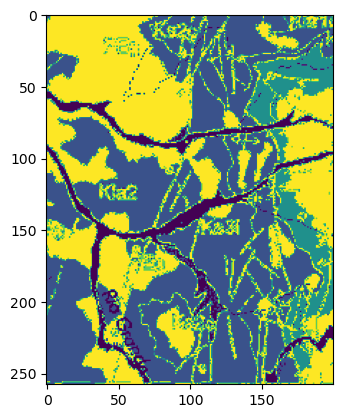

In [17]:
plt.imshow(data[0])

In [12]:
np.save(r"C:\Users\TyHow\Documents\3. Work\ML_test_area\exports\output_6_rasters", data)
np.save(r"C:\Users\TyHow\Documents\3. Work\ML_test_area\exports\output_6_rasters_layer_mappings", feature_mappings)


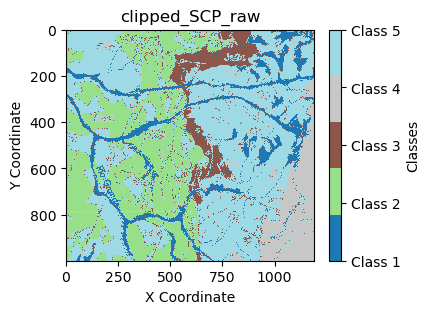

In [22]:
# PLOT
plt.figure(figsize=(4, 3))

layer = 0

# Find the unique, non-NaN values in the data
unique_classes = np.unique(data[layer][~np.isnan(data[layer])])

# Create a colormap with a number of colors equal to the number of unique classes
cmap = plt.get_cmap('tab20', len(unique_classes))

# Plot the data using the correct colormap and normalization
plt.imshow(data[layer], cmap=cmap, interpolation='nearest', aspect='auto')

# Create a colorbar that matches the unique classes
cbar = plt.colorbar(ticks=unique_classes)
cbar.set_label('Classes')

# Set colorbar ticks and labels to match the unique classes
cbar.set_ticks(unique_classes)
cbar.set_ticklabels([f'Class {int(cls)}' for cls in unique_classes])

plt.title(f'{names[layer]}')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()


In [ ]:
#HANDLE NANS (often not needed, but can be used if the next block returns an error related to improper nans)

# Convert "nan" strings to np.nan
def preprocess_data(input_array):
    # Convert input data to a NumPy array if not already
    input_array = np.array(input_array)
    
    # Check if there are any string "nan" values and replace them with np.nan
    input_array = np.where(input_array == "nan", np.nan, input_array)
    
    # Ensure the data is of a floating-point type to handle NaN values properly
    input_array = input_array.astype(np.float32)
    
    return input_array


# Preprocess data to handle "nan" strings
data_preproc = preprocess_data(data)

print(data_preproc)

print("Data type of the array:", data_preproc.dtype)


num_valid_entries = np.sum(~np.isnan(data_preproc))
print(f"Number of valid entries in the data: {num_valid_entries}")


In [27]:
# BATCH MEDIAN FILTER (CUDA) WITH PROPER EDGE HANDLING      ***only needed for categorical files created from semi-auto class or similar algorithms that create a lot of noise. DO NOT RUN ON NUMERICAL (e.g. remote sensing) DATA! 

# Define a custom CUDA kernel for the median filter
median_filter_kernel = cp.RawKernel(r'''
extern "C" __global__
void median_filter(const float* input, float* output, int width, int height, int window_size) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;
    
    int half_window = window_size / 2;
    int window_elements = window_size * window_size;
    float window[1024];  // Assuming max window size of 32x32 for simplicity

    // Ensure the pixel is within bounds
    if (x < width && y < height) {
        int count = 0;

        // Collect the neighboring pixels in the window
        for (int i = -half_window; i <= half_window; ++i) {
            for (int j = -half_window; j <= half_window; ++j) {
                int nx = x + j;
                int ny = y + i;

                // Ensure the neighbor is within image bounds
                if (nx >= 0 && nx < width && ny >= 0 && ny < height) {
                    float val = input[ny * width + nx];
                    if (!isnan(val)) {
                        window[count] = val;
                        count++;
                    }
                }
            }
        }

        // Sort the collected values
        for (int i = 0; i < count - 1; ++i) {
            for (int j = i + 1; j < count; ++j) {
                if (window[i] > window[j]) {
                    float temp = window[i];
                    window[i] = window[j];
                    window[j] = temp;
                }
            }
        }

        // Assign the median value
        if (count > 0) {
            output[y * width + x] = window[count / 2];
        } else {
            output[y * width + x] = __int_as_float(0x7fffffff);  // NaN in CUDA
        }
    }
}
''', 'median_filter')

# Define the block and grid size
block_size = (16, 16)  # Define a block size of 16x16

# Define the smoothing window size
window_size = 20 # Adjust window size as needed

# Prepare an output array for all layers
smoothed_data = np.empty_like(data)

# Iterate over each layer in the 3D array
for i in range(data.shape[0]):
    # Extract the 2D data layer from the 3D array
    data_layer = data[i]  # Extract each layer from the 3D array

    # Convert the data layer to a CuPy array
    data_layer_gpu = cp.array(data_layer)

    # Calculate the grid size for the current layer
    grid_size = ((data_layer_gpu.shape[1] + block_size[0] - 1) // block_size[0],
                 (data_layer_gpu.shape[0] + block_size[1] - 1) // block_size[1])

    # Initialize the output array for the current layer on the GPU
    output_gpu = cp.empty_like(data_layer_gpu)

    # Launch the CUDA kernel for the current layer
    median_filter_kernel(grid_size, block_size, (data_layer_gpu, output_gpu, data_layer_gpu.shape[1], data_layer_gpu.shape[0], window_size))

    # Convert the filtered 2D data layer back to a 2D numpy array
    smoothed_layer = cp.asnumpy(output_gpu)
    
    # Store the smoothed layer back into the 3D numpy array
    smoothed_data[i] = smoothed_layer

# The smoothed_data array now contains all filtered layers
print(smoothed_data.shape)  # Should print the shape of the smoothed 3D array


(1, 1000, 1189)


In [28]:
#PLOT MULTI LAYER

# Initialize the Panel extension
pn.extension()

# Function to plot a specific layer using Matplotlib
def plot_layer_with_classes(layer_index):
    fig = Figure(figsize=(4, 3))
    ax = fig.add_subplot(111)
    
    # Get the unique, non-NaN values in the data for the selected layer
    smoothed_unique_classes = np.unique(smoothed_data[layer_index][~np.isnan(smoothed_data[layer_index])])
    
    # Create a colormap with a number of colors equal to the number of unique classes
    cmap_smooth = plt.get_cmap('tab20', len(smoothed_unique_classes))
    
    # Plot the data using the correct colormap and normalization
    im = ax.imshow(smoothed_data[layer_index], cmap=cmap_smooth, interpolation='nearest', aspect='auto')
    
    # Create a colorbar that matches the unique classes
    cbar = fig.colorbar(im, ax=ax, ticks=smoothed_unique_classes)
    cbar.set_label('Classes')
    
    # Set colorbar ticks and labels to match the unique classes
    cbar.set_ticks(smoothed_unique_classes)
    cbar.set_ticklabels([f'Class {int(cls)}' for cls in smoothed_unique_classes])
    
    ax.set_title(f'{names[layer_index]} (filtered)')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    return pn.pane.Matplotlib(fig, tight=True)

# Create a Panel widget for selecting the layer
layer_slider = pn.widgets.IntSlider(name='Layer Index', start=0, end=smoothed_data.shape[0] - 1, step=1, value=0)

# Bind the plotting function to the slider value
panel = pn.bind(plot_layer_with_classes, layer_index=layer_slider)

# Display the Panel with the slider and plot
pn.Column(layer_slider, panel).servable()


BokehModel(combine_events=True, render_bundle={'docs_json': {'be332e25-025d-4596-99c4-a4d5bb11a038': {'version…

In [ ]:
#PLOT XARRAY 

# Convert numpy array to an xarray DataArray using the existing names
data_xr = xr.DataArray(
    smoothed_data, 
    dims=["layer", "y", "x"], 
    coords={"layer": names, "y": np.arange(smoothed_data.shape[1]), "x": np.arange(smoothed_data.shape[2])},
    name="smoothed_layers"
)

# Plot using xarray with hvplot, allowing easy navigation through layers
plot = data_xr.hvplot.image(
    x="x", 
    y="y", 
    groupby="layer",  # Allows selecting different layers by name
    cmap="tab20", 
    colorbar=True, 
    title="Smoothed Layers",
    aspect='equal',  # Ensures that the aspect ratio is maintained
    width=600,  # Set width to match matplotlib plot dimensions
    height=800  # Set height to match matplotlib plot dimensions
)

# Display the interactive plot
hvplot.show(plot)


In [ ]:
#EXPORT GEOTIFF
# Ask the user to select the output folder
root = Tk()
root.withdraw()  # Hide the root window
output_folder = filedialog.askdirectory(title="Select Output Folder for GeoTIFF Files")

# Export each layer of the smoothed data as an individual GeoTIFF
for i in range(smoothed_data.shape[0]):
    output_raster_map = os.path.join(output_folder, f"filtered_output_layer_{i + 1}.tif")

    # Get the shape of the current layer
    height, width = smoothed_data[i].shape

    with rasterio.open(
        output_raster_map,
        'w',
        driver='GTiff',
        height=height,
        width=width,
        count=1,  # Number of bands
        dtype='float32',
        crs=target_crs,  # Use the CRS from the import step
        transform=target_transform,  # Use the transform from the import step
        nodata=np.nan  # Ensure proper NoData value
    ) as dst:
        # Convert NaN to the appropriate nodata value for GeoTIFF
        layer_data = smoothed_data[i].copy()
        layer_data[np.isnan(layer_data)] = dst.nodata  # Replace NaN with the nodata value

        # Write the current layer to the GeoTIFF file
        dst.write(layer_data, 1)

    print(f"Layer {i+1} exported to {output_raster_map}")
